# Sample Mass-Difference Networks in Metabolomics Data Analysis

Notebook to support the study on the application of **Sample M**ass-**Di**fference **N**etworks as a highly specific competing form of pre-processing procedure for high-resolution metabolomics data.

Mass-Difference Networks are focused into making networks from a list of masses. Each _m/z_ will represent a node. Nodes will be connected if the difference in their masses can be associated to a simple chemical reaction (enzymatic or non-enzymatic) that led to a change in the elemental composition of its metabolite.

The set of mass differences used to build said networks are called a set of MDBs - Mass-Difference-based Building block.

This is notebook `paper_sMDiNs_permuts.ipynb`


## Organization of the Notebook

- Loading up pre-processed and pre-treated datasets databases with intensity-based pre-treated data and data from sMDiNs analyses.
- **Permutation tests generation and figure representation**

Permutation tests are slow to generate.

#### Needed Imports

In [1]:
import itertools
from pathlib import Path

import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal

import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import ticker

import seaborn as sns
import networkx as nx

# Metabolinks package
import metabolinks as mtl
import metabolinks.transformations as transf

# Python files in the repository
import multianalysis as ma

In [2]:
%matplotlib inline

In [3]:
# json for persistence

import json
from time import perf_counter

## Description of dataset records

`datasets` is the global dict that holds all data sets. It is a **dict of dict's**.

Each data set is **represented as a dict**.

Each record has the following fields (keys):

- `name`: the table/figure name of the data set
- `source`: the biological source for each dataset
- `mode`: the aquisition mode
- `alignment`: the alignment used to generate the data matrix
- `data`: the data matrix
- `target`: the sample labels, possibly already integer encoded
- `MDiN`: Mass-Difference Network - Not present here, only on sMDiNsAnalysis notebook
- `<treatment name>`: transformed data matrix / network. These treatment names can be
    - `original`: an alias to `data`
    - `Ionly`: missing value imputed data by 1/5 of the minimum value in each sample in the dataset, only
    - `P`: Pareto scaled data
    - `NP`: Pareto scaled and normalized
    - `NGP`: normalized, glog transformed and Pareto scaled
    - `Ionly_RF`: missing value imputed data by random forests, only
    - `P_RF`: Pareto scaled data
    - `NP_RF`: Pareto scaled and normalized
    - `NGP_RF`: normalized, glog transformed and Pareto scaled
    - **`IDT`: `NGP_RF` or `NGP` - Intensity-based Data pre-Treatment chosen as comparison** based on which of the two performed better for each dataset and each statistical method
    - `sMDiN`: Sample Mass-Difference Networks - Not present here, only on sMDiNsAnalysis notebook
       
- `<sMDiN analysis name>`: data matrix from nework analysis of MDiNs
    - **`Degree`: degree analysis of each sMDiN**
    - **`Betweenness`: betweenness centrality analysis of each sMDiN**
    - **`Closeness`: closeness centrality of analysis of each sMDiN**
    - **`MDBI`: analysis on the impact of each MDB (Mass-Difference based building-block) on building each sMDiN**
    - **`GCD11`: Graphlet Correlation Distance of 11 different orbits (maximum of 4-node graphlets) between each sMDiN.**

The keys of `datasets` may be shared with dicts holding records resulting from comparison analysis.

Here are the keys (and respective names) of datasets used in this study:

- GD_neg_global2 (GDg2-)
- GD_pos_global2 (GDg2+)
- GD_neg_class2 (GDc2-)
- GD_pos_class2 (GDc2+)
- YD (YD)
- vitis_types (GD types)
- HD (HD)

#### Data Pre-Treatment

For information on the **commonly used intensity based data pre-treatments** and about the **benchmark datasets**, see notebook `paper_sMDiNs_database_prep.ipynb`.

For information on the **building** and the different **network analysis methods** used for the **Sample MDiNs** and information about the Mass-Difference-based Building blocks (**MDBs**), see notebook `paper_sMDiNs_sMDiNsAnalysis.ipynb`.

### Reading datasets database

In [4]:
# Read benchmark datasets
path = Path.cwd() / "store_files" / 'processed_data.json'
storepath = Path.cwd() / "store_files" / 'processed_data.h5'
with pd.HDFStore(storepath) as store:

    with open(path, encoding='utf8') as read_file:
        datasets = json.load(read_file)
    
    for dskey, dataset in datasets.items():
        for key in dataset:
            value = dataset[key]
            if isinstance(value, str) and value.startswith("INSTORE"):
                storekey = value.split("_", 1)[1]
                dataset[key] = store[storekey]
#datasets

In [5]:
# Selecting a placeholder for the Intensity-based Data pre-Treatment (IDT)
# Chosen for each dataset and each method based on which between NGP and NGP_RF generated the best results
for name, ds in datasets.items():
    ds['IDT'] = ds['NGP_RF']  

Extra Possibly Useful Data

In [6]:
# Atomic masses - https://ciaaw.org/atomic-masses.htm
#Isotopic abundances-https://ciaaw.org/isotopic-abundances.htm/https://www.degruyter.com/view/journals/pac/88/3/article-p293.xml
# Isotopic abundances from Pure Appl. Chem. 2016; 88(3): 293–306,
# Isotopic compositions of the elements 2013 (IUPAC Technical Report), doi: 10.1515/pac-2015-0503

chemdict = {'H':(1.0078250322, 0.999844),
            'C':(12.000000000, 0.988922),
            'N':(14.003074004, 0.996337),
            'O':(15.994914619, 0.9976206),
            'Na':(22.98976928, 1.0),
            'P':(30.973761998, 1.0),
            'S':(31.972071174, 0.9504074),
            'Cl':(34.9688527, 0.757647),
            'F':(18.998403163, 1.0),
            'C13':(13.003354835, 0.011078) # Carbon 13 isotope
           } 

# electron mass from NIST http://physics.nist.gov/cgi-bin/cuu/Value?meu|search_for=electron+mass
electron_mass = 0.000548579909065

In [7]:
# Chemical Formula transformations (MDBs chosen)
MDBs = ['H2','CH2','CO2','O','CHOH','NCH','O(N-H-)','S','CONH','PO3H','NH3(O-)','SO3','CO', 'C2H2O', 'H2O']

### Colors for plots to ensure consistency

#### 11 variety grapevine data sets

In [8]:
# customize label colors for 11 grapevine varieties

colours = sns.color_palette('Blues', 3)
colours.extend(sns.color_palette('Greens', 3))
#colours = sns.cubehelix_palette(n_colors=6, start=2, rot=0, dark=0.2, light=.9, reverse=True)
colours.extend(sns.color_palette('flare', 5))

ordered_vitis_labels = ('CAN','RIP','ROT','RU','LAB','SYL','REG','CS','PN','RL','TRI')

vitis_label_colors = {lbl: c for lbl, c in zip(ordered_vitis_labels, colours)}

tab20bcols = sns.color_palette('tab20b', 20)
tab20ccols = sns.color_palette('tab20c', 20)
tab20cols = sns.color_palette('tab20', 20)
tab10cols = sns.color_palette('tab10', 10)
dark2cols = sns.color_palette('Dark2', 8)

vitis_label_colors['RU'] = tab20bcols[8]
vitis_label_colors['CAN'] = tab20ccols[5]
vitis_label_colors['REG'] = tab10cols[3]

for name in datasets:
    if name.startswith('GD'):
        datasets[name]['label_colors'] = vitis_label_colors
        datasets[name]['sample_colors'] = [vitis_label_colors[lbl] for lbl in datasets[name]['target']]

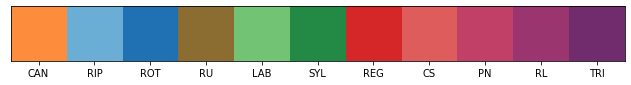

In [9]:
sns.palplot(vitis_label_colors.values())
new_ticks = plt.xticks(range(len(ordered_vitis_labels)), ordered_vitis_labels)

#### 5 yeast strains

In [10]:
# customize label colors for 5 yeast strains

colours = sns.color_palette('Set1', 5)
yeast_classes = datasets['YD']['classes']
yeast_label_colors = {lbl: c for lbl, c in zip(yeast_classes, colours)}
datasets['YD']['label_colors'] = yeast_label_colors
datasets['YD']['sample_colors'] = [yeast_label_colors[lbl] for lbl in datasets['YD']['target']]

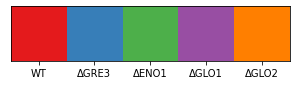

In [11]:
sns.palplot(yeast_label_colors.values())
new_ticks = plt.xticks(range(len(yeast_classes)), yeast_classes)

#### 2 classes of Vitis types (wild and _vinifera_)

In [12]:
# customize label colors for 2 types of Vitis varieties

colours = [vitis_label_colors['SYL'], vitis_label_colors['TRI']]
vitis_type_classes = datasets['vitis_types']['classes']
vitis_types_label_colors = {lbl: c for lbl, c in zip(vitis_type_classes, colours)}
datasets['vitis_types']['label_colors'] = vitis_types_label_colors
datasets['vitis_types']['sample_colors'] = [vitis_types_label_colors[lbl] for lbl in datasets['vitis_types']['target']]

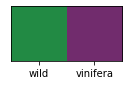

In [13]:
sns.palplot(datasets['vitis_types']['label_colors'].values())
new_ticks = plt.xticks(range(len(datasets['vitis_types']['classes'])), datasets['vitis_types']['classes'])

#### 2 HD classes

In [14]:
# customize label colors for 2 HD classes

colours = sns.color_palette('Set1', 2)
hd_label_colors = {lbl: c for lbl, c in zip(datasets['HD']['classes'], colours)}
datasets['HD']['label_colors'] = hd_label_colors
datasets['HD']['sample_colors'] = [hd_label_colors[lbl] for lbl in datasets['HD']['target']]

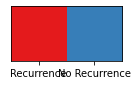

In [15]:
sns.palplot(hd_label_colors.values())
new_ticks = plt.xticks(range(len(datasets['HD']['classes'])), datasets['HD']['classes'])

Samples and respective target labels of each dataset

In [16]:
def styled_sample_labels(sample_names, sample_labels, label_colors):

    meta_table = pd.DataFrame({'label': sample_labels,
                               'sample': sample_names}).set_index('sample').T

    def apply_label_color(val):
        red, green, blue = label_colors[val]
        red, green, blue = int(red*255), int(green*255), int(blue*255)   
        hexcode = '#%02x%02x%02x' % (red, green, blue)
        css = f'background-color: {hexcode}'
        return css
    
    return meta_table.style.applymap(apply_label_color)

In [17]:
parsed = mtl.parse_data(datasets['GD_pos_class2']['data'], labels_loc='label')
y = datasets['GD_pos_class2']['target']
label_colors = datasets['GD_pos_class2']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,14,15,16,29,30,31,8,9,10,23,24,25,38,39,40,17,18,19,26,27,28,20,21,22,35,36,37,11,12,13,32,33,34
label,CAN,CAN,CAN,CS,CS,CS,LAB,LAB,LAB,PN,PN,PN,REG,REG,REG,RIP,RIP,RIP,RL,RL,RL,ROT,ROT,ROT,RU,RU,RU,SYL,SYL,SYL,TRI,TRI,TRI


In [18]:
parsed = mtl.parse_data(datasets['YD']['data'])
y = datasets['YD']['target']
label_colors = datasets['YD']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
label,WT,WT,WT,ΔGRE3,ΔGRE3,ΔGRE3,ΔENO1,ΔENO1,ΔENO1,ΔGLO1,ΔGLO1,ΔGLO1,ΔGLO2,ΔGLO2,ΔGLO2


In [19]:
parsed = mtl.parse_data(datasets['vitis_types']['data'], labels_loc='label')
y = datasets['vitis_types']['target']
label_colors = datasets['vitis_types']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,14,15,16,29,30,31,8,9,10,23,24,25,38,39,40,17,18,19,26,27,28,20,21,22,35,36,37,11,12,13,32,33,34
label,wild,wild,wild,vinifera,vinifera,vinifera,wild,wild,wild,vinifera,vinifera,vinifera,vinifera,vinifera,vinifera,wild,wild,wild,vinifera,vinifera,vinifera,wild,wild,wild,wild,wild,wild,wild,wild,wild,vinifera,vinifera,vinifera


In [20]:
parsed = mtl.parse_data(datasets['HD']['data'])
y = datasets['HD']['target']
label_colors = datasets['HD']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,S10_1,S10_2,S10_3,S15_1,S15_2,S15_3,S25_1,S25_2,S25_3,S34_1,S34_2,S34_3,S35_1,S35_2,S35_3,S37_1,S37_2,S37_3,S39_1,S39_2,S39_3,S45_1,S45_2,S45_3,S48_1,S48_2,S48_3,S49_1,S49_2,S49_3,S50_1,S50_2,S50_3,S51_1,S51_2,S51_3,S52_1,S52_2,S52_3,S53_1,S53_2,S53_3,S54_1,S54_2,S54_3,S57_1,S57_2,S57_3,S58_1,S58_2,S58_3,S59_1,S59_2,S59_3,S60_1,S60_2,S60_3,S61_1,S61_2,S61_3,S62_1,S62_2,S62_3,S63_1,S63_2,S63_3,S64_1,S64_2,S64_3,S65_1,S65_2,S65_3,S68_1,S68_2,S68_3,S69A_1,S69A_2,S69A_3,S69B_1,S69B_2,S69B_3,S71_1,S71_2,S71_3,S73_1,S73_2,S73_3,S74_1,S74_2,S74_3,S75_1,S75_2,S75_3,S76_1,S76_2,S76_3,S78_1,S78_2,S78_3,S79_1,S79_2,S79_3,S80_1,S80_2,S80_3,S81_1,S81_2,S81_3,S82_1,S82_2,S82_3,S83_1,S83_2,S83_3,S1_1,S1_2,S1_3,S2_1,S2_2,S2_3,S3_1,S3_2,S3_3,S4_1,S4_2,S4_3,S5_1,S5_2,S5_3,S6_1,S6_2,S6_3,S8_1,S8_2,S8_3,S9_1,S9_2,S9_3,S11_1,S11_2,S11_3,S12_1,S12_2,S12_3,S13A_1,S13A_2,S13A_3,S13B_1,S13B_2,S13B_3,S14_1,S14_2,S14_3,S16_1,S16_2,S16_3,S17_1,S17_2,S17_3,S18_1,S18_2,S18_3,S19_1,S19_2,S19_3,S20A_1,S20A_2,S20A_3,S20B_1,S20B_2,S20B_3,S21_1,S21_2,S21_3,S22_1,S22_2,S22_3,S23_1,S23_2,S23_3,S24_1,S24_2,S24_3,S26_1,S26_2,S26_3,S27_1,S27_2,S27_3,S28_1,S28_2,S28_3,S29_1,S29_2,S29_3,S30_1,S30_2,S30_3,S31_1,S31_2,S31_3,S32_1,S32_2,S32_3,S33_1,S33_2,S33_3,S36_1,S36_2,S36_3,S38_1,S38_2,S38_3,S41_1,S41_2,S41_3,S42_1,S42_2,S42_3,S43_1,S43_2,S43_3,S44_1,S44_2,S44_3,S46_1,S46_2,S46_3,S47_1,S47_2,S47_3,S66A_1,S66A_2,S66A_3,S66B_1,S66B_2,S66B_3,S67_1,S67_2,S67_3,S70_1,S70_2,S70_3,S72_1,S72_2,S72_3,S77_1,S77_2,S77_3
label,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recu

#### Colors for the pre-treatments / sMDiN analysis metrics for the plots

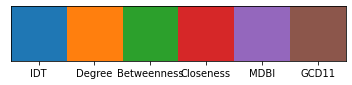

In [21]:
# customize colors for the intensity-based pre-treatment and analysis metrics of sample MDiNs
treatments = ('IDT', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD11')

treat_colors = tab10cols[:6]
#treat_colors.extend(tab10cols[6:8])
#treat_colors.extend(tab10cols[4:6])
treatment_colors = {lbl: c for lbl, c in zip(treatments, treat_colors)}

sns.palplot(treatment_colors.values())
new_ticks = plt.xticks(range(len(treatment_colors)), treatment_colors)

## Supervised Statistical Analysis - Permutation Tests

The Supervised Statistical Analysis methods used will be Random Forest and PLS-DA.

The performance of the classifiers will be evaluated by their predictive **accuracy** (which will always be estimated by internal stratified 3-fold cross-validation or 5-fold cross-validation in `vitis_types` and in `HD`).

Each method will be applied to the differently-treated datasets for each of the benchmark datasets.

## Permutation Tests (Very Slow)

Permutation tests is based on shuffling the labels of the different samples, shuflling the groups where they belong with the intent to see if the classifier tested, whether it is Random Forest or PLS-DA found a significant class structure in the data - assess the significance of the predictive accuracy results. 

For that a random k-fold cross-validation is performed on the original dataset (to serve as a comparation point) and on X permutations of datasets with labels randomly shuffled around. The models are evaluated by their predictive accuracies. 

The empirical p-value is given by (the number of times the permutation accuracy was bigger than the random k-fold cross-validation made with the original dataset + 1) / (number of permutations + 1) (source: Ojala and Garriga, 2010).

Ojala M, Garriga GC. Permutation Tests for Studying Classifier Performance. In: 2009 Ninth IEEE International Conference on Data Mining. ; 2009:908-913. doi:10.1109/ICDM.2009.108

Histograms with the prediction accuracy of the different permutations were plotted and compared to the accuracy got with the original dataset.

### Permutation Tests - Random Forests

Use of `permutation_RF` function from multianalysis.py. See details about the application of this function in the multianalysis.py file.

Use `GENERATE = True` to perform permutation tests and persist results in json

In [22]:
GENERATE = True #False

In [23]:
if GENERATE:
    iter_num=500 # number of permutations

    permuts_RF = []

    to_permute = [name for name in datasets]
    for name in to_permute:
        for treatment in ('IDT', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD11'):
            dataset = datasets[name]
            # Choice based on prior results on which treatment tends to be better for the dataset/classifier combination
            if treatment == 'IDT':
                if name == 'GD_pos_global2':
                    dataset[treatment] = dataset['NGP_RF'] 
                else:
                    dataset[treatment] = dataset['NGP'] 
                    
            print(f'{iter_num} permutations (Random Forest) for {name} with treatment {treatment}', end=' ...')
            n_fold = 5 if name in ('vitis_types', 'HD') else 3
            start = perf_counter()
            permutations = ma.permutation_RF(dataset[treatment], dataset['target'], iter_num=iter_num, n_fold=n_fold, n_trees=100)
            res = {'dataset': name, 'treatment': treatment,
                   'non_permuted_CV': permutations[0],
                   'permutations': permutations[1],
                   'p-value': permutations[2]}       
            permuts_RF.append(res)
            end = perf_counter()
            print(f'Done! took {(end - start):.3f} s')
    
    # Store in json file
    fname = 'store_files/permuts_rf.json'
    with open(fname, "w", encoding='utf8') as write_file:
        json.dump(permuts_RF, write_file)

500 permutations (Random Forest) for GD_neg_global2 with treatment IDT ...Done! took 361.526 s
500 permutations (Random Forest) for GD_neg_global2 with treatment Degree ...Done! took 332.331 s
500 permutations (Random Forest) for GD_neg_global2 with treatment Betweenness ...Done! took 321.408 s
500 permutations (Random Forest) for GD_neg_global2 with treatment Closeness ...Done! took 313.393 s
500 permutations (Random Forest) for GD_neg_global2 with treatment MDBI ...Done! took 236.099 s
500 permutations (Random Forest) for GD_neg_global2 with treatment GCD11 ...Done! took 238.772 s
500 permutations (Random Forest) for GD_pos_global2 with treatment IDT ...Done! took 580.296 s
500 permutations (Random Forest) for GD_pos_global2 with treatment Degree ...Done! took 770.249 s
500 permutations (Random Forest) for GD_pos_global2 with treatment Betweenness ...Done! took 572.906 s
500 permutations (Random Forest) for GD_pos_global2 with treatment Closeness ...Done! took 402.679 s
500 permutati

### Permutation Tests - PLS-DA

Use of `permutation_PLSDA` function from multianalysis.py. See details about the application of this function in the multianalysis.py file.

In [24]:
%%capture --no-stdout
if GENERATE:
    iter_num=500

    permuts_PLSDA = []

    to_permute = [name for name in datasets]
    for name in to_permute:
        for treatment in ('IDT', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD11'):
            dataset = datasets[name]
            scale = True
            # Choice based on prior results on which treatment tends to be better for the dataset/classifier combination
            if treatment == 'IDT':
                scale = False
                if name in ('GD_neg_global2', 'HD'):
                    dataset[treatment] = dataset['NGP_RF'] 
                else:
                    dataset[treatment] = dataset['NGP'] 
            
            print(f'Permutation test (PLS-DA) for {name} with treatment {treatment}', end=' ...')
            if name.startswith('GD'):
                n_comp = 11
            elif name.startswith('HD'):
                n_comp = 13
            else:
                n_comp = 6
            if treatment == 'MDBI':
                n_comp = 5
                
            n_fold = 5 if name in ('vitis_types', 'HD') else 3
            
            start = perf_counter()
            permutations = ma.permutation_PLSDA(dataset[treatment], dataset['target'], n_comp=11,
                                                iter_num=iter_num, n_fold=n_fold, scale=scale)
            res = {'dataset': name, 'treatment': treatment,
                   'non_permuted_CV': permutations[0],
                   'permutations': permutations[1],
                   'p-value': permutations[2]}
            permuts_PLSDA.append(res)
            end = perf_counter()
            print(f'Done! took {(end - start):.3f} s')
            
    # Store in json file
    fname = 'store_files/permuts_plsda.json'
    with open(fname, "w", encoding='utf8') as write_file:
        json.dump(permuts_PLSDA, write_file)

Permutation test (PLS-DA) for GD_neg_global2 with treatment IDT ...Done! took 192.268 s
Permutation test (PLS-DA) for GD_neg_global2 with treatment Degree ...Done! took 214.086 s
Permutation test (PLS-DA) for GD_neg_global2 with treatment Betweenness ...Done! took 205.498 s
Permutation test (PLS-DA) for GD_neg_global2 with treatment Closeness ...Done! took 207.803 s
Permutation test (PLS-DA) for GD_neg_global2 with treatment MDBI ...Done! took 22.384 s
Permutation test (PLS-DA) for GD_neg_global2 with treatment GCD11 ...Done! took 23.522 s
Permutation test (PLS-DA) for GD_pos_global2 with treatment IDT ...Done! took 369.020 s
Permutation test (PLS-DA) for GD_pos_global2 with treatment Degree ...Done! took 370.301 s
Permutation test (PLS-DA) for GD_pos_global2 with treatment Betweenness ...Done! took 356.556 s
Permutation test (PLS-DA) for GD_pos_global2 with treatment Closeness ...Done! took 377.479 s
Permutation test (PLS-DA) for GD_pos_global2 with treatment MDBI ...Done! took 21.473

In [25]:
# Get data from json file - random forests
fname = 'store_files/permuts_rf.json'
with open(fname, "r", encoding='utf8') as read_file:
    permuts_RF = json.load(read_file)

for p in permuts_RF:
    print(f"{p['dataset']:<20}{p['treatment']:<8}{p['p-value']:10.5f}")

GD_neg_global2      IDT        0.00200
GD_neg_global2      Degree     0.00200
GD_neg_global2      Betweenness   0.00200
GD_neg_global2      Closeness   0.00200
GD_neg_global2      MDBI       0.00200
GD_neg_global2      GCD11      0.00200
GD_pos_global2      IDT        0.00200
GD_pos_global2      Degree     0.00200
GD_pos_global2      Betweenness   0.00200
GD_pos_global2      Closeness   0.00200
GD_pos_global2      MDBI       0.00200
GD_pos_global2      GCD11      0.00399
GD_neg_class2       IDT        0.00200
GD_neg_class2       Degree     0.00200
GD_neg_class2       Betweenness   0.00200
GD_neg_class2       Closeness   0.00200
GD_neg_class2       MDBI       0.00200
GD_neg_class2       GCD11      0.00200
GD_pos_class2       IDT        0.00200
GD_pos_class2       Degree     0.00200
GD_pos_class2       Betweenness   0.00200
GD_pos_class2       Closeness   0.00200
GD_pos_class2       MDBI       0.00200
GD_pos_class2       GCD11      0.00200
YD                  IDT        0.00200
YD       

In [26]:
# Get data from json file - PLS-DA
fname = 'store_files/permuts_plsda.json'
with open(fname, "r", encoding='utf8') as read_file:
    permuts_PLSDA = json.load(read_file)

for p in permuts_PLSDA:
    print(f"{p['dataset']:<20}{p['treatment']:<8}{p['p-value']:10.5f}")

GD_neg_global2      IDT        0.00200
GD_neg_global2      Degree     0.00200
GD_neg_global2      Betweenness   0.00200
GD_neg_global2      Closeness   0.00200
GD_neg_global2      MDBI       0.00200
GD_neg_global2      GCD11      0.00998
GD_pos_global2      IDT        0.00200
GD_pos_global2      Degree     0.00200
GD_pos_global2      Betweenness   0.00200
GD_pos_global2      Closeness   0.00200
GD_pos_global2      MDBI       0.00200
GD_pos_global2      GCD11      0.00200
GD_neg_class2       IDT        0.00200
GD_neg_class2       Degree     0.00200
GD_neg_class2       Betweenness   0.00200
GD_neg_class2       Closeness   0.00200
GD_neg_class2       MDBI       0.00200
GD_neg_class2       GCD11      0.00200
GD_pos_class2       IDT        0.00200
GD_pos_class2       Degree     0.00200
GD_pos_class2       Betweenness   0.00200
GD_pos_class2       Closeness   0.00200
GD_pos_class2       MDBI       0.00200
GD_pos_class2       GCD11      0.00200
YD                  IDT        0.00200
YD       

#### Plot the Permutations test results - Histograms

Nº Occurences (of the permutations) vs CV prediction acuracy - The distribution of average prediction accuracy of X permutations

1st Figure - Random Forest

2nd Figure - PLS-DA

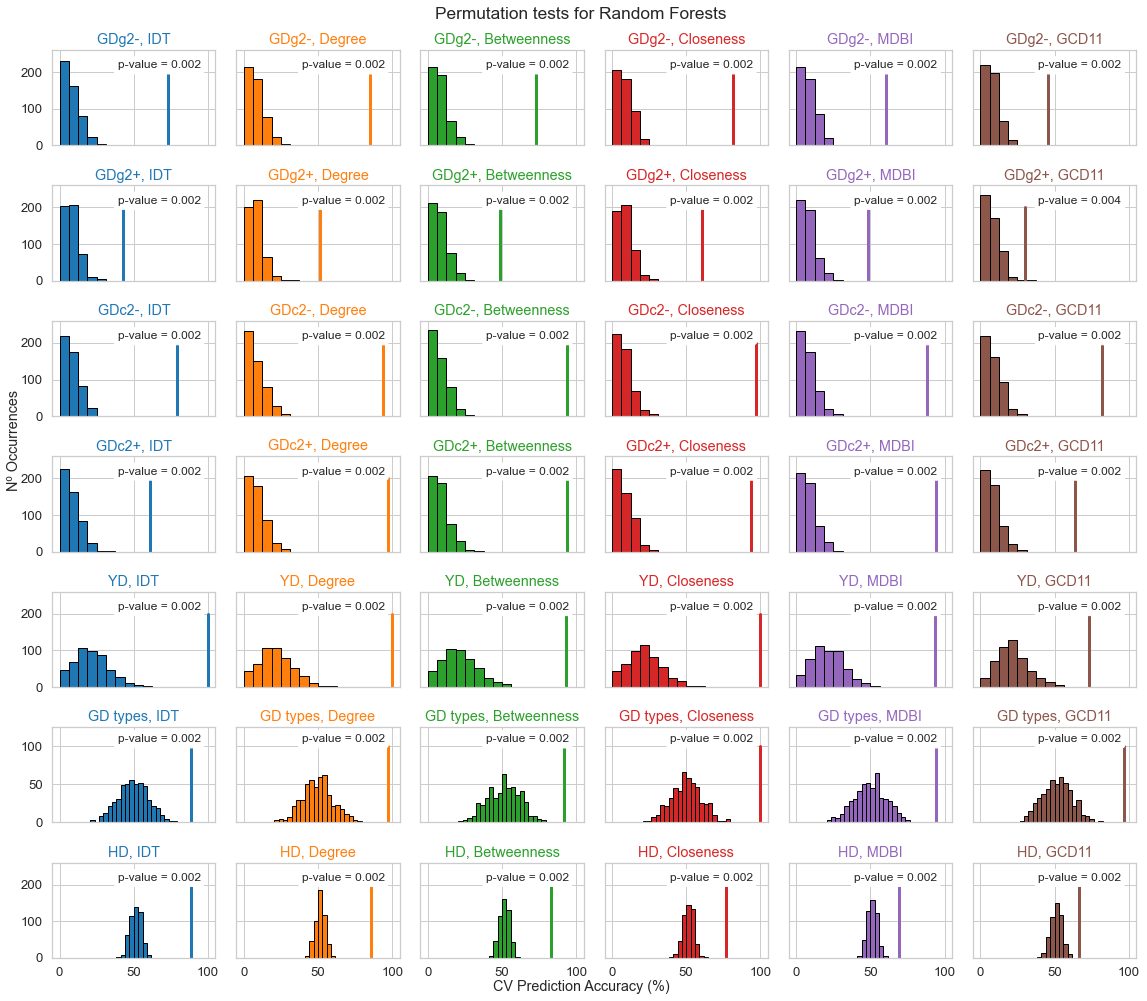

In [27]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, axes = plt.subplots(7, 6, figsize = (16,14), sharey='row', sharex='col')
        colors = treat_colors
        ylim = [0,200]
        treatments = ['IDT', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD11']
        
        for row, dskey in enumerate(datasets):

            to_plot = [p for p in permuts_RF if p['dataset'] == dskey]

            n_labels = len(datasets[dskey]['target'])
            n_bins = 34 if dskey in ('vitis_types', 'HD') else 16
            
            if dskey == 'vitis_types':
                ylim = [0,100]
            else:
                ylim = [0,200]

            for ax, p, tname, color in zip(axes[row].ravel(), to_plot, treatments, colors):
                ax.hist(np.array(p['permutations'])*100, range=(0, 100.01), label=name + ' Permutations',
                        bins=n_bins, edgecolor='black', color=color)
                #ax.axvline(p['non_permuted_CV']*100)

                ax.plot(2 * [p['non_permuted_CV'] * 100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
                         label=name + ' (pvalue %.5f)' % p['p-value'], solid_capstyle='round')

                props = dict(boxstyle='round', facecolor='white', alpha=1)
                
                if dskey != 'vitis_types':
                    ax.text(95, 210, 'p-value = %.3f' % p['p-value'], bbox=props, ha='right', fontsize='small')
                    ax.set_title(f"{datasets[dskey]['name']}, {tname}", color=color)
                    ax.set_ylim(0,260)
                else:
                    ax.text(95, 105, 'p-value = %.3f' % p['p-value'], bbox=props, ha='right', fontsize='small')
                    ax.set_title(f"{datasets[dskey]['name']}, {tname}", color=color)
                    ax.set_ylim(0,125)

        f.text(0.5, 0.015, 'CV Prediction Accuracy (%)', ha='center', va='top')
        f.text(0.008, 0.6, 'Nº Occurrences', ha='center', va='top',rotation=90)
        
        f.suptitle(f'Permutation tests for Random Forests')
        plt.tight_layout()
        f.savefig('images/permutations_RF.pdf', dpi=600)
        f.savefig('images/permutations_RF.png', dpi=600)
        plt.show()

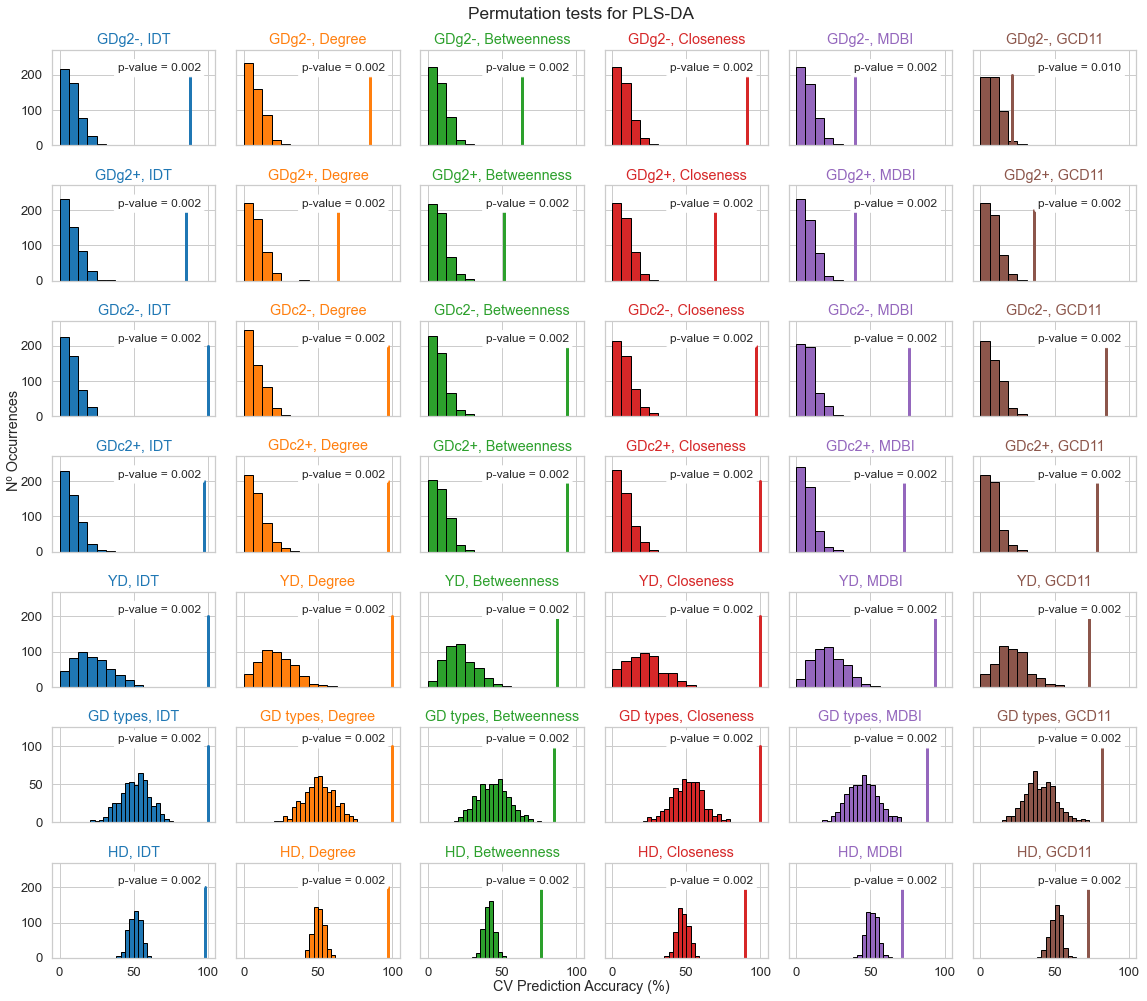

In [28]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, axes = plt.subplots(7, 6, figsize = (16,14), sharey='row', sharex='col')
        colors = treat_colors
        ylim = [0,200]
        treatments = ['IDT', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD11']
        
        for row, dskey in enumerate(datasets):

            to_plot = [p for p in permuts_PLSDA if p['dataset'] == dskey]

            n_labels = len(datasets[dskey]['target'])
            
            n_bins = 34 if dskey in ('vitis_types', 'HD') else 16
            
            if dskey == 'vitis_types':
                ylim = [0,100]
            else:
                ylim = [0,200]


            for ax, p, tname, color in zip(axes[row].ravel(), to_plot, treatments, colors):
                ax.hist(np.array(p['permutations'])*100, range=(0, 100.01), label=name + ' Permutations',
                        bins=n_bins, edgecolor='black', color=color)
                #ax.axvline(p['non_permuted_CV']*100)

                ax.plot(2 * [p['non_permuted_CV'] * 100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
                         label=name + ' (pvalue %.5f)' % p['p-value'], solid_capstyle='round')

                props = dict(boxstyle='round', facecolor='white', alpha=1)
                
                if dskey != 'vitis_types':
                    ax.text(95, 210, 'p-value = %.3f' % p['p-value'], bbox=props, ha='right', fontsize='small')
                    ax.set_title(f"{datasets[dskey]['name']}, {tname}", color=color)
                    ax.set_ylim(0,270)
                else:
                    ax.text(95, 105, 'p-value = %.3f' % p['p-value'], bbox=props, ha='right', fontsize='small')
                    ax.set_title(f"{datasets[dskey]['name']}, {tname}", color=color)
                    ax.set_ylim(0,125)

        f.text(0.5, 0.015, 'CV Prediction Accuracy (%)', ha='center', va='top')
        f.text(0.008, 0.6, 'Nº Occurrences', ha='center', va='top',rotation=90)
        
        
        f.suptitle(f'Permutation tests for PLS-DA')
        plt.tight_layout()
        f.savefig('images/permutations_PLSDA.pdf', dpi=600)
        f.savefig('images/permutations_PLSDA.png', dpi=600)
        plt.show()

In [29]:
permuts_PLSDA[0].keys()

dict_keys(['dataset', 'treatment', 'non_permuted_CV', 'permutations', 'p-value'])

In [30]:
def endminus(x):
    if x.endswith('-'):
        return x.replace('-', '−')
    else:
        return x

In [31]:
l = 0
permut_table = pd.DataFrame(columns=['Dataset', 'Treatment', 'Classifier', 'p-value'])
for i in permuts_RF:
    name = datasets[i['dataset']]['name']
    if name.endswith('-'):
        endminus(name)
    permut_table.loc[l] = (name, i['treatment'], 'RF', i['p-value'])
    l = l+1

for i in permuts_PLSDA:
    name = datasets[i['dataset']]['name']
    if name.endswith('-'):
        endminus(name)
    permut_table.loc[l] = (name, i['treatment'], 'PLS-DA', i['p-value'])
    l = l+1

In [32]:
#permut_table.to_excel('Table S2_Perm.xlsx')

In [33]:
#permut_table.to_csv('Table S2_Perm.csv')